# AGC + calver coffea on coffea-casa

We'll base this on a few sources:
- https://github.com/iris-hep/analysis-grand-challenge/tree/main/analyses/cms-open-data-ttbar (AGC, of course)
- https://github.com/alexander-held/CompHEP-2023-AGC (contains a simplified version of AGC)
- https://github.com/nsmith-/TTGamma_LongExercise/ (credit Nick Smith for helpful examples of the new API)
- (and if time allows, weight features: https://github.com/CoffeaTeam/coffea/blob/backports-v0.7.x/binder/accumulators.ipynb / https://coffeateam.github.io/coffea/api/coffea.analysis_tools.Weights.html#coffea.analysis_tools.Weights.partial_weight)

In [1]:
from pathlib import Path

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools

import warnings

import utils
utils.plotting.set_style()

warnings.filterwarnings("ignore")
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here


client = Client("tls://localhost:8786")

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.3
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.4.0


### Produce an AGC histogram with Dask (no coffea yet)

In [2]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electron[events.Electron.pt > 30 & (np.abs(events.Electron.eta) < 2.1)]
    selected_muons = events.Muon[events.Muon.pt > 30 & (np.abs(events.Muon.eta) < 2.1)]
    selected_jets = events.Jet[events.Jet.pt > 25 & (np.abs(events.Jet.eta) < 2.4)]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)

    # apply filters
    selected_jets = selected_jets[event_filters]

    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    return ak.flatten(trijet_mass)

Reading in the ROOT file, we can now create a Dask task graph for the calculations and plot that we want to make using `dask-awkward` and `hist.dask`

In [3]:
ttbar_file = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/"\
    "TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_"\
    "mcRun2_asymptotic_v12_ext4-v1_80000_0007.root"

events = NanoEventsFactory.from_root({ttbar_file: "Events"}, schemaclass=NanoAODSchema).events()

# create the task graph to build a histogram
reconstructed_top_mass = calculate_trijet_mass(events)
hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)

and then once we're ready we can execute the task graph with `.compute()` to get our visualization

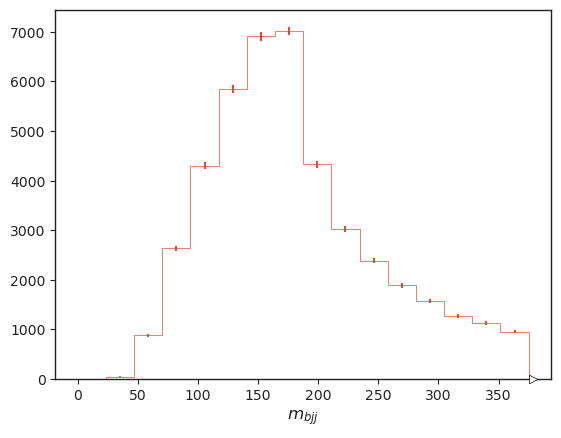

In [4]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

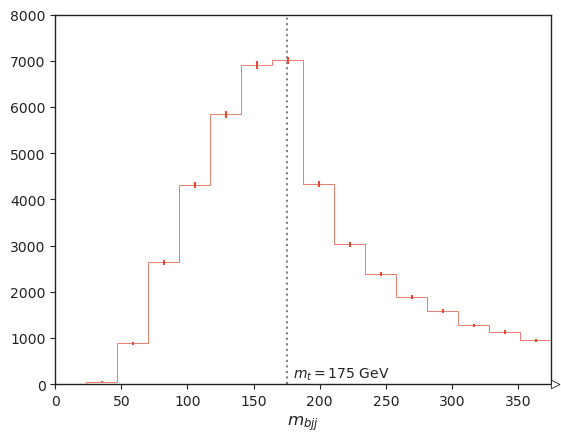

In [5]:
# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175, 0, 10000, colors=["grey"], linestyle="dotted")
ax.text(180, 150, "$m_{t} = 175$ GeV")
ax.set_xlim([0, 375])
ax.set_ylim([0, 8000])

fig.savefig(fig_dir / "trijet_mass.png", dpi=300)
fig

This all matches the (non-Dask) versions of the plots from last summer — see the notebook linked above. Not surprising, but reassuring!

### Time for coffea

We'll first write the functions to compute the observable and do the histogramming using `awkward-dask` and `hist.dask` again

In [6]:
B_TAG_THRESHOLD = 0.5

# perform object selection
def object_selection(events):
    elecs = events.Electron
    muons = events.Muon
    jets = events.Jet

    electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
    muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                 (muons.pfRelIso04_all < 0.15))
    jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

    # Only keep objects that pass our requirements
    elecs = elecs[electron_reqs]
    muons = muons[muon_reqs]
    jets = jets[jet_reqs]

    return elecs, muons, jets


# event selection for 4j1b and 4j2b
def region_selection(elecs, muons, jets):
    ######### Store boolean masks with PackedSelection ##########
    selections = PackedSelection(dtype='uint64')
    # Basic selection criteria
    selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
    selections.add("atleast_4j", ak.num(jets) >= 4)
    selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
    selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
    # Complex selection criteria
    selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
    selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

    return selections.all("4j1b"), selections.all("4j2b")


# observable calculation for 4j2b
def calculate_m_reco_top(jets):
    # reconstruct hadronic top as bjj system with largest pT
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2,
                                    np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass)

    return observable


# create histograms with observables
def create_histograms(events):
    hist_4j1b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="HT", label=r"$H_T$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    hist_4j2b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    process = events.metadata["process"]  # "ttbar" etc.
    variation = events.metadata["variation"]  # "nominal" etc.
    process_label = events.metadata["process_label"]  # nicer LaTeX labels

    # normalization for MC
    x_sec = events.metadata["xsec"]
    nevts_total = events.metadata["nevts"]
    lumi = 3378 # /pb
    if process != "data":
        xsec_weight = x_sec * lumi / nevts_total
    else:
        xsec_weight = 1

    elecs, muons, jets = object_selection(events)

    # region selection
    selection_4j1b, selection_4j2b = region_selection(elecs, muons, jets)

    # 4j1b: HT
    observable_4j1b = ak.sum(jets[selection_4j1b].pt, axis=-1)
    hist_4j1b.fill(observable_4j1b, weight=xsec_weight, process=process_label, variation=variation)

    # 4j2b: m_reco_top
    observable_4j2b = calculate_m_reco_top(jets[selection_4j2b])
    hist_4j2b.fill(observable_4j2b, weight=xsec_weight, process=process_label, variation=variation)

    return {"4j1b": hist_4j1b, "4j2b": hist_4j2b}

and prepare the fileset we need

In [7]:
# fileset preparation
N_FILES_MAX_PER_SAMPLE = 1
# compared to coffea 0.7: list of file paths becomes list of dicts (path: trename)
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE)

# fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}  # to only process nominal ttbar
# fileset

Now we can start using `coffea` with its Dask capabilities. One of the things we need to do is to build the full task graph, which requires looping over all the sample variations (`samples`)

In [8]:
%%time
# pre-process
step_size = utils.config.config["benchmarking"]["STEPSIZE"]
samples, _ = dataset_tools.preprocess(fileset, step_size)

# workaround for https://github.com/CoffeaTeam/coffea/issues/1050 (metadata gets dropped, already fixed)
for k, v in samples.items():
    v["metadata"] = fileset[k]["metadata"]

CPU times: user 121 ms, sys: 1.63 ms, total: 122 ms
Wall time: 35.3 s


In [9]:
%%time
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_histograms, samples, uproot_options={"allow_read_errors_with_report": True})

CPU times: user 6.41 s, sys: 87.7 ms, total: 6.5 s
Wall time: 7.69 s


and then we can finally execute the full task graph with Dask

In [10]:
%%time
# execute
((out, report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple

print(f"total time spent in uproot reading data (or some related metric?): {ak.sum([v['duration'] for v in report.values()]):.2f} s")
exec_time =  ak.sum([v['duration'] for v in report.values()])

total time spent in uproot reading data (or some related metric?): 1605.85 s
CPU times: user 1.43 s, sys: 16 ms, total: 1.45 s
Wall time: 2min 1s


In [11]:
metrics = {}

In [12]:
utils.metrics.track_metrics(metrics, fileset, exec_time, N_FILES_MAX_PER_SAMPLE)

metrics saved as metrics/coffea_casa-20240602-083855.json


To visualize the results, we need to first stack the serperate histograms that were computed individually

In [13]:
# stack all the histograms together (we processed each sample separately)
full_histogram_4j1b = sum([v["4j1b"] for v in out.values()])
full_histogram_4j2b = sum([v["4j2b"] for v in out.values()])

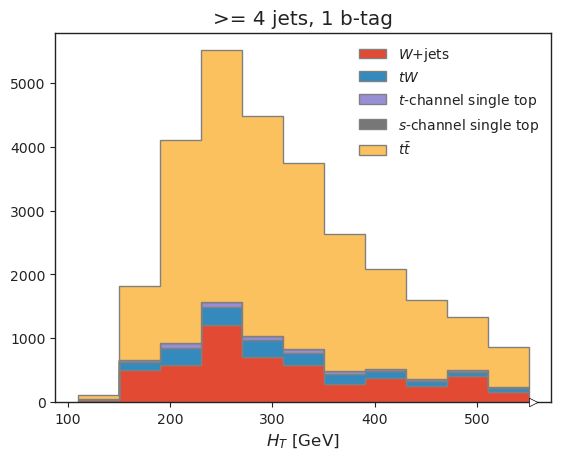

In [14]:
artists = full_histogram_4j1b[120j::hist.rebin(2), :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, 1 b-tag");

fig.savefig(fig_dir / "coffea_4j_1b.png", dpi=300)

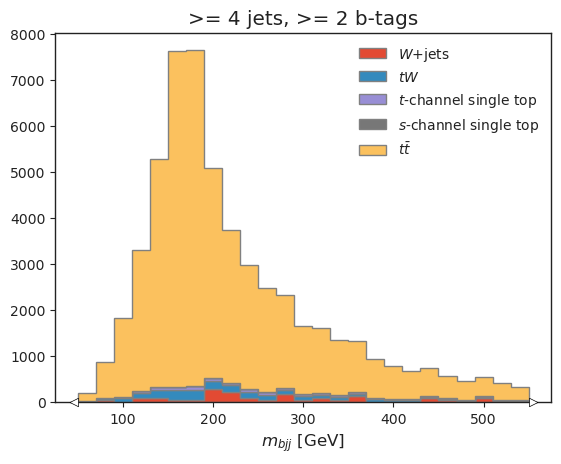

In [15]:
artists = full_histogram_4j2b[:, :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, >= 2 b-tags");

fig.savefig(fig_dir / "coffea_4j_2b.png", dpi=300)

This is a plot you can compare to the one in the full AGC notebook — you'll notice they look the same. Success!

If we now investigate the task graph for the nominal $t\bar{t}$ sample in the optimzied view, which hides from us some of the complexity of the graph we created.

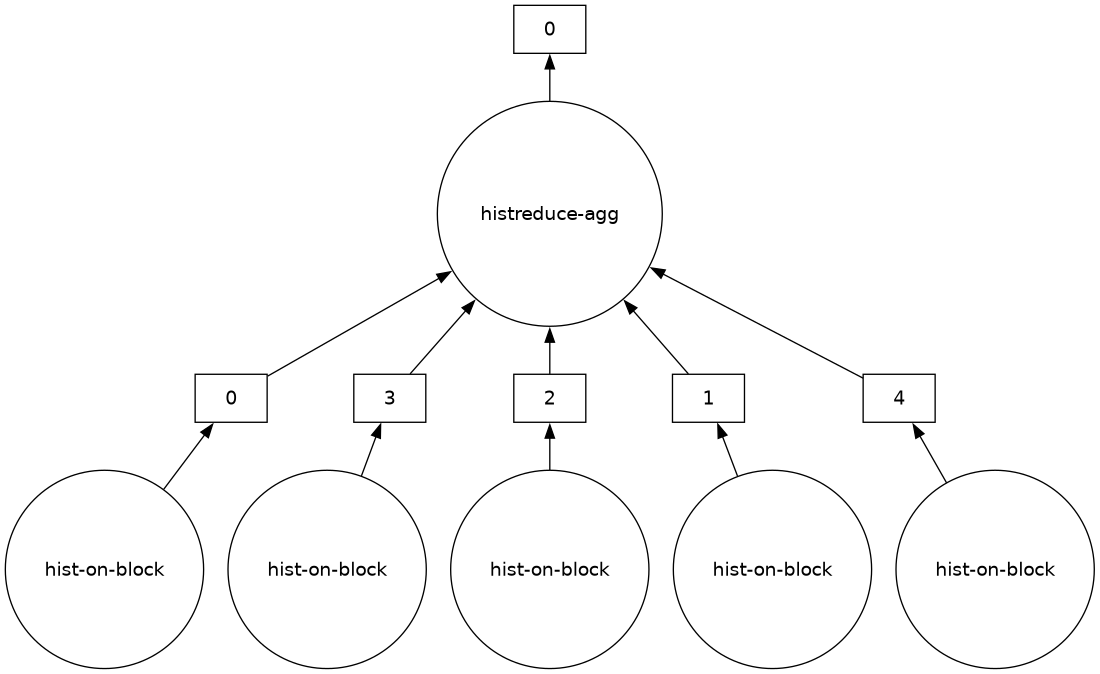

In [16]:
tasks[0]["ttbar__nominal"]["4j2b"].visualize(optimize_graph=True)

In [17]:
# "100 layers is a large task graph" on IRIS-HEP Slack, 100 layers happen quickly!
for region in ["4j1b", "4j2b"]:
    for process, task in tasks[0].items():
        print(f"{process:>30} {region} {len(task[region].dask.layers)}")

                ttbar__nominal 4j1b 78
              ttbar__scaledown 4j1b 78
                ttbar__scaleup 4j1b 78
                 ttbar__ME_var 4j1b 78
                 ttbar__PS_var 4j1b 78
    single_top_s_chan__nominal 4j1b 78
    single_top_t_chan__nominal 4j1b 78
        single_top_tW__nominal 4j1b 78
                wjets__nominal 4j1b 78
                ttbar__nominal 4j2b 101
              ttbar__scaledown 4j2b 101
                ttbar__scaleup 4j2b 101
                 ttbar__ME_var 4j2b 101
                 ttbar__PS_var 4j2b 101
    single_top_s_chan__nominal 4j2b 101
    single_top_t_chan__nominal 4j2b 101
        single_top_tW__nominal 4j2b 101
                wjets__nominal 4j2b 101


In [18]:
# columns getting read for a given task
dak.necessary_columns(tasks[0]["ttbar__nominal"]["4j2b"])

{'from-uproot-6ce5d853d15d3abac3ad135753109d1d': frozenset({'Electron_cutBased',
            'Electron_eta',
            'Electron_pt',
            'Electron_sip3d',
            'Jet_btagCSVV2',
            'Jet_eta',
            'Jet_jetId',
            'Jet_mass',
            'Jet_phi',
            'Jet_pt',
            'Muon_eta',
            'Muon_pfRelIso04_all',
            'Muon_pt',
            'Muon_sip3d',
            'Muon_tightId',
            'nElectron',
            'nJet',
            'nMuon'})}